# Mario vs Wario: Image Classification in Pytorch

A short exercise on image classification. I use the same dataset as in the previous [notebook](https://github.com/erykml/mario_vs_wario/blob/master/mario_vs_wario.ipynb), however, this time I build the CNN in PyTorch and using Google Colab.

I will present 2 approaches to building the architecture of the CNNs: using Class or Sequential. The networks will have exactly the same architecture, the idea is get familiar with both methodologies. Also due to the fact that I will be using GPU, I use larger image size than in the previous exercise (128x128).

I do not own any rights to the videos or game-related content.

## Installing libraries (Google Colab part) ----

This part is only intended in case of running the notebook in Google Colab or on a machine with a GPU and Cuda. In case of running on CPU, skip to 1.2.

In [1]:
# inspect the os 
!cat /etc/*-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.1 LTS"
NAME="Ubuntu"
VERSION="18.04.1 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.1 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [3]:
# inspect GPU and RAM ----

# memory footprint support libraries/code
!pip install gputil
!pip install psutil
!pip install humanize

import GPUtil as GPU
import os
import humanize
import psutil
!ln - sf / opt/bin/nvidia-smi / usr/bin/nvidia-smi

GPUs = GPU.getGPUs()
gpu = GPUs[0]


def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available),
          " | Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(
        gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


printm()

  Running setup.py bdist_wheel for gputil ... - \ done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
ln: target 'usr/bin/nvidia-smi' is not a directory
Gen RAM Free: 12.9 GB  | Proc size: 142.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [4]:
#nvidia-smi is a profiling command for the GPU
!nvidia-smi 

Fri Jan 25 21:06:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
# inspect cuda version 
!nvcc --version 

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148


In [6]:
# install PyTorch 
!pip3 install torch torchvision

    100% |████████████████████████████████| 2.0MB 15.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
# kill the VM (just in case)
#!kill -9 -1

When using Colab it is important to store files in a Colab directory, not on the mounted Google Drive. The first cell contains code for connecting to Google Drive and mounting the drive so that we can access all files stored there. However, training Neural Networks (even with GPU enabled) with data loaded from Google Drive will most of the times be significantly slower than training it locally on a CPU. That is due to copying all the data between Colab and Drive directories, which is incredibly slow.

To tackle this problem, I store images in appropriate folders (named after their respective classes), zip the training and test set separately and download the files by using `gdown` and the link to Google Drive (when you click download shareable link in Drive's UI). Then I unpack the folders with images to the designated directories.

In the last step I remove a leftover directory.

In [0]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [9]:
!pip install gdown

# create directory for storing data
!mkdir -p data

# download zip file with training set
!gdown https://drive.google.com/uc?id=1z_vO2muBgzNGIa7JtY8OPmaeUC348jj4 && unzip -qq training_set.zip -d data/training_set
!rm training_set.zip

# download zip with test set
!gdown https://drive.google.com/uc?id=1ziwxAVrbDRfUTYMrFu0sn1B8OH-6gvej && unzip -qq test_set.zip -d data/test_set
!rm test_set.zip

# remove some leftover dir
!rm -r /content/data/test_set/__MACOSX/

# change dir to the one with data 
!cd /content/data

Downloading...
From: https://drive.google.com/uc?id=1z_vO2muBgzNGIa7JtY8OPmaeUC348jj4
To: /content/training_set.zip
174MB [00:02, 83.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ziwxAVrbDRfUTYMrFu0sn1B8OH-6gvej
To: /content/test_set.zip
43.4MB [00:00, 76.6MB/s]


In [0]:
# restart runtime for PIL to work

import os

def restart_runtime():
    os.kill(os.getpid(), 9)

restart_runtime()

## Loading Libraries ----

In [1]:
# Loading libraries ----

# misc
import os
import shutil
import numpy as np
import pandas as pd
from collections import OrderedDict
import time

# sci-kit learn
from sklearn import metrics

# plots
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# torch 
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    pin_memory = False
else:
    print('CUDA is available!  Training on GPU ...')
    pin_memory = True

CUDA is available!  Training on GPU ...


## UDFs ----

In [0]:
def imshow(img):
    '''
    Helper function to un-normalize and display an image
    
    Input:
    img - tensor
    '''
    
    # move to CPU in case working on GPU
    if type(img) is not np.ndarray:
        if 'cuda' in img.type():
            img = img.cpu()
        
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = metrics.confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.4f}'.format(metrics.accuracy_score(y_truth, y_pred)))
    print('Precision: {:.4f}'.format(metrics.precision_score(y_truth, y_pred)))
    print('Recall: {:.4f}'.format(metrics.recall_score(y_truth, y_pred)))
    print('F1: {:.4f}'.format(metrics.f1_score(y_truth, y_pred)))

## Loading data ----

In this part I load and pre-process the data (images). I will describe the process step by step:

1. First, I define some parameters and the transformations I want to carry out on the images (resize to 128x128, convert to tensors and normalize). This is also the step where I could carry out image augmentation (random cropping, shearing, rotations etc.). However, as this particular problem is about classifying video games' images, I think it does not make sense to apply these transformations, as the images will no longer resemble the original screenshots. But if you are building a cat/dog classifier and do not have a really large dataset (and even if you do), this would be the place to apply the transformations.
2. I specify the directory for train/test data and apply the selected transformations.
3. I randomly select a subset of indices from the training set to use them for validation. I also create `SubsetRandomSampler`s for sampling images from given indices (not the entire dataset).
4. I create `DataLoader`s by combining datasets with samplers. I use `pin_memory = True` in case of training on a GPU (recommended setting). For the `test_loader` I also shuffle the dataset, otherwise it would first take all observations from one class, then all from the second one, without any reshuffling. In case of the test set, this actually does not matter. But it is good to be aware of this functionality.

In [0]:
# 1. defining parameters ----

# number of subprocesses to use for data loading
num_workers = 0
# number of samples to load per batch
batch_size = 32
# % of training set to use as validation
valid_size = 0.2

# define transformations that will be applied to images
image_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 2. define the datasets ----
train_data = datasets.ImageFolder(root='data/training_set/', transform=image_transforms)
test_data = datasets.ImageFolder(root='data/test_set/', transform=image_transforms)

# 3. obtain indices that will be used for validation ----
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# 4. prepare data loaders (combine dataset with sampler) ----
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           sampler = train_sampler, 
                                           num_workers = num_workers,
                                           pin_memory = pin_memory)
valid_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size, 
                                           sampler = valid_sampler, 
                                           num_workers = num_workers,
                                           pin_memory = pin_memory)
test_loader = torch.utils.data.DataLoader(test_data,
                                          shuffle = True,
                                          batch_size = batch_size, 
                                          num_workers = num_workers,
                                          pin_memory = pin_memory)

# specify the image classes ----
classes = ['mario', 'wario'] # mario is 0, wario is 1

In the code below I inspect 10 randomly selected images. As `DataLoaders` work as iterators, I first use `iter()` followed by `next()` to obtain randomly selected images and their labels (from the first batch).

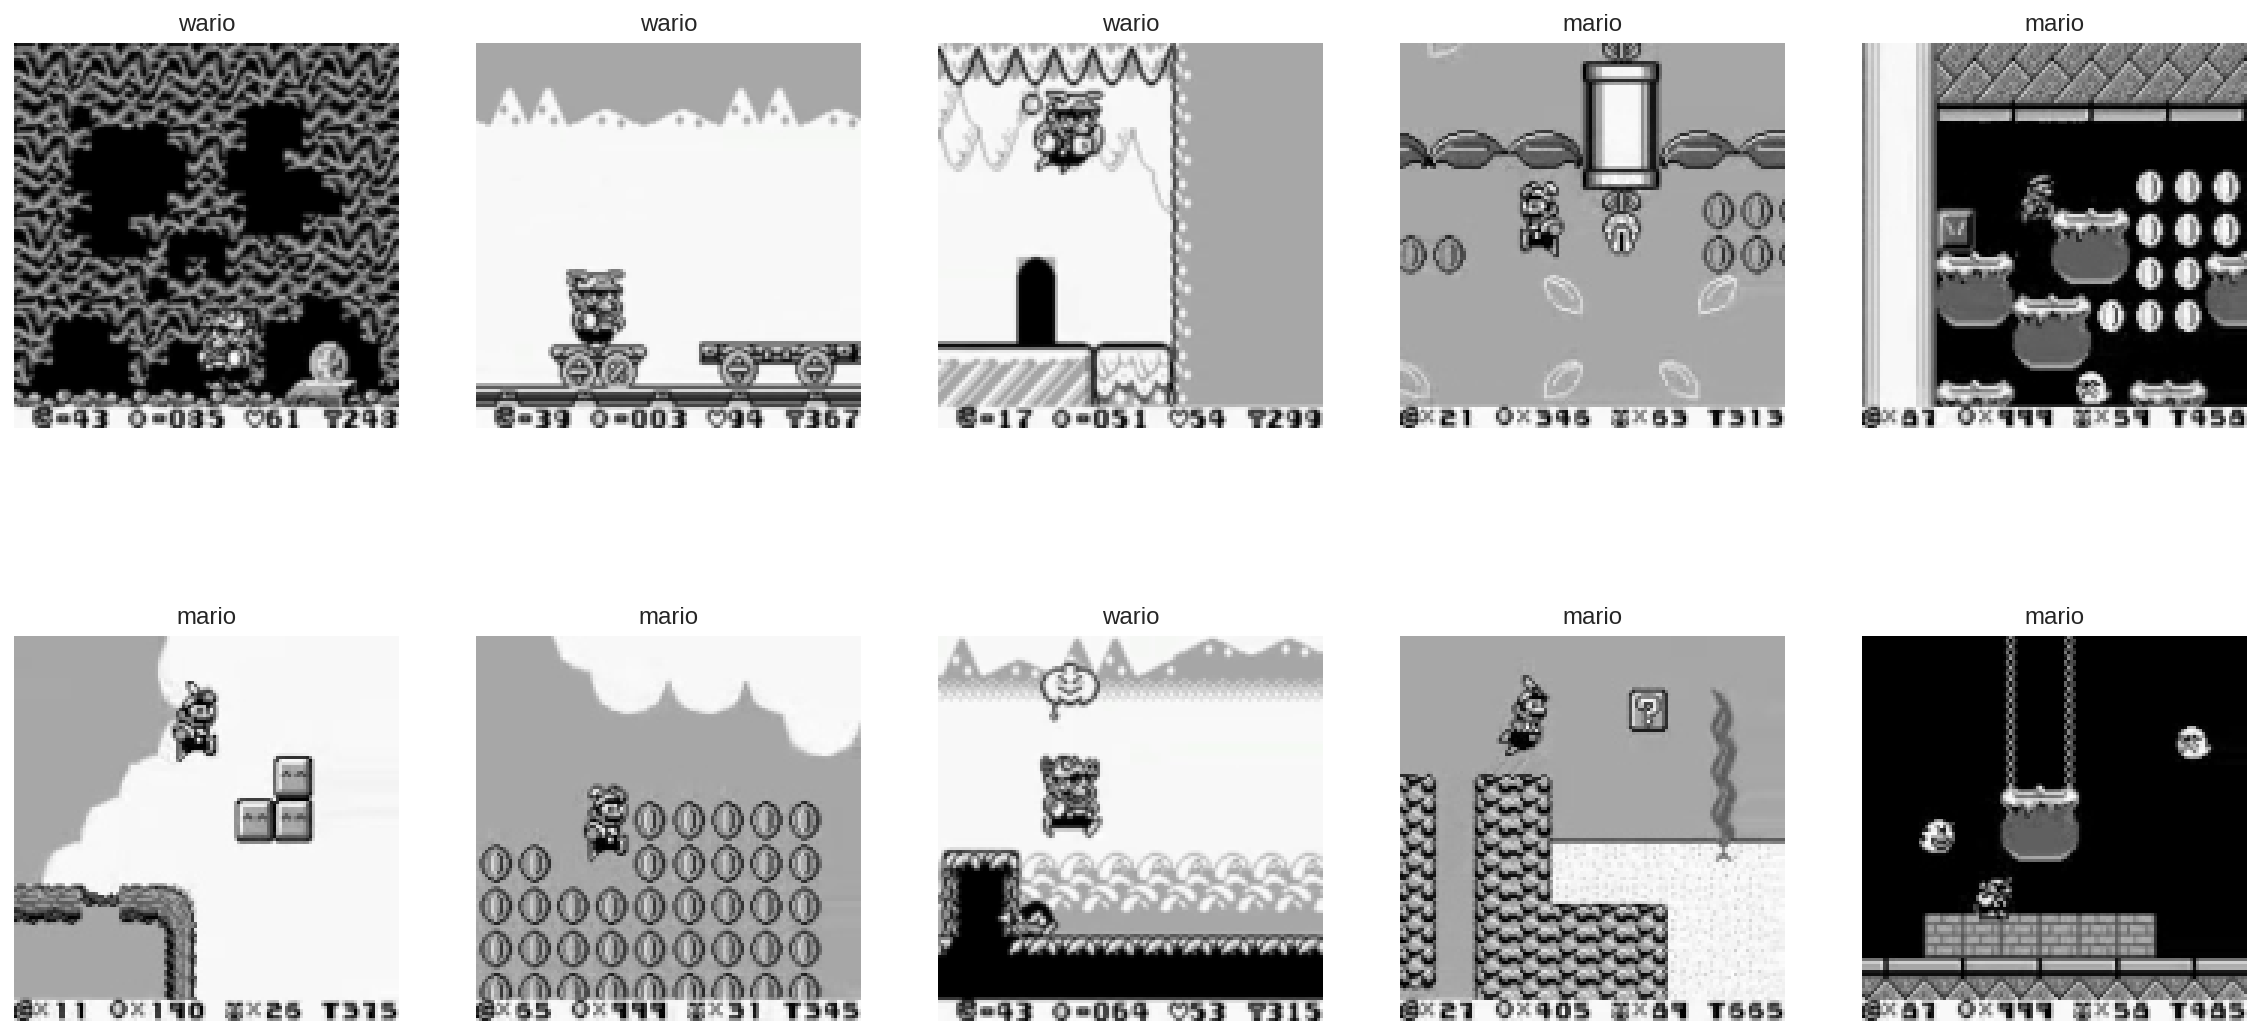

In [61]:
# inspect loaded images ----

# obtain one batch of training images
dataiter = iter(train_loader)
data, target = dataiter.next()
data = data.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(data[idx])
    ax.set_title(classes[target[idx]])

## CNN architecture 

I present two approaches to defining the architecture of Neural Networks. The first one is by building a class, which inherits from nn.Module. The second one is more similar to Keras and we create a sequence of layers. There is no right or wrong here, depends on personal preferences.

In both cases I use the same architecture, so only one should be used before training.

### Class approach ----

I define a class inheriting from `nn.Module`, which combined with `super().__init__()` creates a class that tracks the architecture of the neural network and provides a variety of methods and attributes. It is important to note that the class must inherit from `nn.Module`.

The class must contain two methods: `__init__` and `forward`.

I give a little more explanation on each of the required methods:

* `__init__` - it is used to define the attributes of the class and populate specified values at instantiation. One rule is to always call the `super()` method in order to initialize the parent class. Aside from this, we can define all the layers, which have some parameters to be optimized (weights to be adjusted). We do not need to define activation functions, such as `relu` here, because given the same input they will always return the same output. The order of defined layers does not matter, as these are purely definitions, not the architecture specifying how the layers are connected. 

* `forward` - In this method we define the connections between layers. We specify the order in which they are connected and ultimately return the output of the network. On a side note, the variable does not have to be called `x`, what matters it it passing through the layers in the correct order.

In [36]:
# create the class containing the architecture of the network (inherits from nn.Module)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # define the layers
        
        # cheatsheet
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
        #           padding=0, dilation=1, groups=1, bias=True)
        
        # conv layer (input: 128x128x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer (input 64x64x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # conv layer (input: 32x32x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer 
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(128, 1)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 16 * 16)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)


### Sequential approach ----

The `Sequential` approach might be immediately similar for those who used Keras. I create an `OrderedDict` with each layer specified in the order they are to be executed. The reason for using `OrderedDict` is that I can give the layers meaningful names. Without doing so, their names would be integers.

At the beginning I define a `Flatten` class, which basically reshapes the matrix into a long vector, as it is normally done in case of CNNs. The `OrderedDict` is placed within `nn.Sequential`, which defines our model. 

In [37]:
# create class Flatten to flatten the tensor
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

# use OrderedDict to give meaningful names for layers
model = nn.Sequential(OrderedDict([
                        ('conv_1', nn.Conv2d(3, 16, 3, padding=1)),
                        ('relu_1', nn.ReLU()),
                        ('max_pool_1', nn.MaxPool2d(2, 2)),
                        ('conv_2', nn.Conv2d(16, 32, 3, padding=1)),
                        ('relu_2', nn.ReLU()),
                        ('max_pool_2', nn.MaxPool2d(2, 2)),
                        ('conv_3', nn.Conv2d(32, 64, 3, padding=1)),
                        ('relu_3', nn.ReLU()),
                        ('max_pool_3', nn.MaxPool2d(2, 2)),
                        ('flatten', Flatten()),
                        ('dropout_1', nn.Dropout(0.25)),
                        ('fc_1', nn.Linear(64 * 16 * 16, 128)),
                        ('relu_4', nn.ReLU()),
                        ('dropout', nn.Dropout(0.25)),
                        ('fc_2', nn.Linear(128, 1))
]))

print(model)

Sequential(
  (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (dropout_1): Dropout(p=0.25)
  (fc_1): Linear(in_features=16384, out_features=128, bias=True)
  (relu_4): ReLU()
  (dropout): Dropout(p=0.25)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
)


### Loss function and optimizer ----

The first step is to move the model to Cuda in case it will be trained on a GPU. Then, I specify the loss function for a binary classification problem and the optimizer as Stochastic Gradient Descent with a learning rate of 0.01. 

In [0]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()
    
# specify loss function (Binary cross-entropy)
criterion = nn.BCEWithLogitsLoss()

# specify optimizer - SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training the network ----

There is already a lot of material online about the steps one needs to take in order to train neural networks. I will only outline the steps:
1. Forward pass through the network (as specified in the `forward()` method)
2. Calculate the loss based on network's output
3. Backward pass through the network with `loss.backward()` to calculate the gradients
4. Update the weights by taking a step with the optimizer

There are also a few other things worth mentioning:
* `optimizer.zero_grad()` - when doing multiple backwards passes with the same parameters, the gradients are accumulating. That is why we need to zero the gradients on each forward pass.
* `model.train()/model.eval()` - while training we might be using dropout to prevent overfitting. However, for prediction/validation we want to use the entire network, thus we need to change the dropout probability to 0 (switch it off) by using `model.eval()`. To go back to training mode we use `model.train()`.
* `torch.no_grad()` - turn off gradients for validation, saves memory and computations

To have a re-usable framework for training CNNs I encapsulate the logic within a function. I assume that the network will be trained with a training and validation loss. Of course, it could be further parametrised and the validation set could only be considered if the parameters are not `None`. However, for the case of this notebook I believe this is enough.

In [0]:
def train_cnn(model, train_loader, valid_loader, 
              criterion, optimizer, n_epochs = 30, train_on_gpu = False, 
              save_model_on_improvement = True, plot_loss = True):
    '''
    Function for training the CNN given input parameters. Can be run on CPU or GPU.
    The function automatically verifies whether the selected criterion is Binary cross-entropy and if so
    converts tensors to appropriate type.
    
    Inputs:
    model - architecture of the neural network defined using either Class approach or Sequential
    train_loader - loader of the dataset used for training
    valid_loader - loader of the dataset used for validation
    criterion - loss function
    optimizer - selected optimizer
    n_epochs - number of epochs
    train_on_gpu - boolean; whether to train using GPU
    save_model_on_improvement - boolean; whether to save the model when validation loss decreases compared to previous epoch
    plot_loss - boolean; whether to plot the train/validation loss over epochs
    '''
    valid_loss_min = np.Inf # track change in validation loss
    train_losses, valid_losses = [], []
    times = []

    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # keep track of time
        if train_on_gpu:
            torch.cuda.synchronize()
        t0 = time.perf_counter()

        # train the model ----
        
        model.train()
        for data, target in train_loader:

            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # convert long to float tensor if eval. criterion = BCEWithLogitsLoss
            if ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss)
               and (target.type() == 'torch.cuda.LongTensor')
               and train_on_gpu):
                target = target.type(torch.cuda.FloatTensor)
            elif ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss) and 
                 (target.type() == 'torch.LongTensor')):
                target = target.type(torch.FloatTensor)

            # reset the gradients of all optimized variables
            optimizer.zero_grad()

            # 1. forward pass
            output = model(data).squeeze()

            # 2. calculate the batch loss
            loss = criterion(output, target)

            # 3. backward pass
            loss.backward()

            # 4. perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item()*data.size(0)

        # validate the model ----
        
        # turn off gradients 
        with torch.no_grad():
            model.eval()
            for data, target in valid_loader:

                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # convert long to float tensor if eval. criterion = BCEWithLogitsLoss
                if ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss)
                   and (target.type() == 'torch.cuda.LongTensor')
                   and train_on_gpu):
                    target = target.type(torch.cuda.FloatTensor)
                elif ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss) and 
                     (target.type() == 'torch.LongTensor')):
                    target = target.type(torch.FloatTensor)

                # 1. forward pass
                output = model(data).squeeze()

                # 2. calculate the batch loss
                loss = criterion(output, target)

                # update average validation loss 
                valid_loss += loss.item()*data.size(0)

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        train_losses.append(train_loss)

        valid_loss = valid_loss/len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        # append time of entire epoch (not counting model saving etc.)
        if train_on_gpu:
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        times.append(t1 - t0)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining time: {:.2f} s'.format(
            epoch, train_loss, valid_loss, t1 - t0))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_mvw_' + str(epoch) + '.pt')
            valid_loss_min = valid_loss
    
    if plot_loss:
        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        plt.legend(frameon=False)
    
    return model

Epoch: 1 	Training Loss: 0.544599 	Validation Loss: 0.131243 	Training time: 45.66 s
Validation loss decreased (inf --> 0.131243).  Saving model ...
Epoch: 2 	Training Loss: 0.481803 	Validation Loss: 0.095791 	Training time: 45.49 s
Validation loss decreased (0.131243 --> 0.095791).  Saving model ...
Epoch: 3 	Training Loss: 0.200413 	Validation Loss: 0.010939 	Training time: 45.51 s
Validation loss decreased (0.095791 --> 0.010939).  Saving model ...
Epoch: 4 	Training Loss: 0.044061 	Validation Loss: 0.006175 	Training time: 45.75 s
Validation loss decreased (0.010939 --> 0.006175).  Saving model ...
Epoch: 5 	Training Loss: 0.029209 	Validation Loss: 0.003460 	Training time: 45.75 s
Validation loss decreased (0.006175 --> 0.003460).  Saving model ...
Epoch: 6 	Training Loss: 0.021183 	Validation Loss: 0.002596 	Training time: 45.45 s
Validation loss decreased (0.003460 --> 0.002596).  Saving model ...
Epoch: 7 	Training Loss: 0.016238 	Validation Loss: 0.002509 	Training time: 44.8

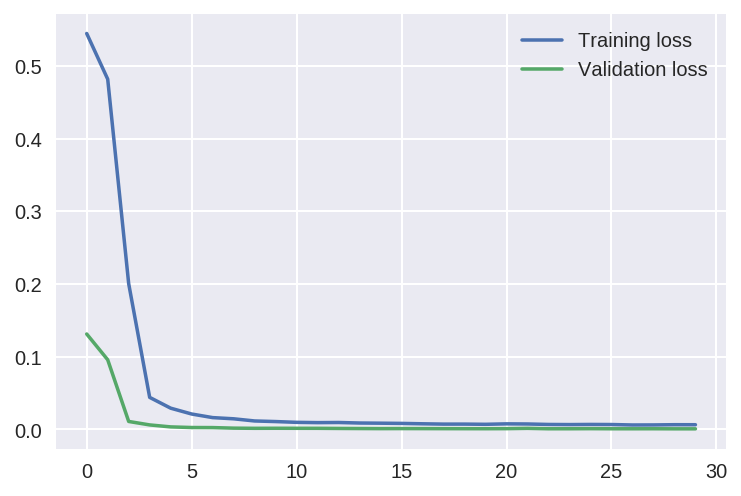

In [40]:
model = train_cnn(model, train_loader, valid_loader, 
                  criterion, optimizer, n_epochs = 30, train_on_gpu = True)

I inspect the plot presenting the evolution of training/valuation loss over epochs. Our goal is not only to reduce the training loss, but also to reduce the validation loss. If the training loss continued to decrease while the validation loss increased, we would observe overfitting - the model would not be able to generalise well on data not seen during training. In this case we see that the model's losses do not decrease significantly after 7th epoch (or even earlier, depending on preferences).

Seeing this, I will load the model from the 7th epoch. By saving all the intermediate models I am able to see what the test set performance would look like (just in case I would like to compare).

## Evaluating the results on a test set ----

In this part I evaluate the results of the network on the test set, i.e. the one that the network has not seen during the training. I write a similar script to the validation one, with the difference being the amount of metrics I store for evaluation.

In [0]:
# load the stored model if not executed in sequence
# model's architecture should be defined prior to loading

model.load_state_dict(torch.load('model_mvw_7.pt'))

In [58]:
# define sigmoid function
f_sigmoid = nn.Sigmoid()

# define test loss
test_loss = 0.0

# keeping track for incorrectly classified images
incorrect_images = []
true_label = []
incorrect_label = []

# keeping track o results for all images
y_true = []
y_pred = []

# evaluating the results of the network ----

# switch model to eval mode for evaluation
model.eval()

# iterate over test data
with torch.no_grad():
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # convert long to float tensor if eval. criterion = BCEWithLogitsLoss
        if ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss)
           and (target.type() == 'torch.cuda.LongTensor')
           and train_on_gpu):
            target = target.type(torch.cuda.FloatTensor)
            target_byte = target.type(torch.cuda.ByteTensor)
        elif ((type(criterion) == torch.nn.modules.loss.BCEWithLogitsLoss) and 
             (target.type() == 'torch.LongTensor')):
            target = target.type(torch.FloatTensor)
            target_byte = target.type(torch.ByteTensor)
            
        # forward pass
        output = model(data).squeeze()
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update test loss 
        test_loss += loss.item()*data.size(0)
        
        # convert output to probabilities
        pred_proba = f_sigmoid(output)
        
        # convert probability to class, standard threshold of 0.5
        pred = pred_proba >= 0.5
        
        # keep track of y values
        y_true.extend(target.type(torch.ByteTensor).data.view_as(pred).numpy().tolist() if not train_on_gpu else np.squeeze(target.type(torch.ByteTensor).data.view_as(pred).cpu().numpy().tolist()))
        y_pred.extend(pred.numpy().tolist() if not train_on_gpu else np.squeeze(pred.cpu().numpy().tolist()))
        
        # compare predictions to true label
        if train_on_gpu:
            to_compare = target.type(torch.cuda.ByteTensor).data.view_as(pred)
        else:
            to_compare = target.type(torch.ByteTensor).data.view_as(pred)
            
        correct_tensor = pred.eq(to_compare)
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        
        # calculate test accuracy for each object class
        for i in range(min(data.shape[0], batch_size)): # take the smaller of batch_size or data
            
            # saving the incorrectly classified images
            if correct[i].item() == 0:
                incorrect_images.append(data[i])
                true_label.append(int(target.data[i].item()))
                incorrect_label.append(pred[i].item())
                
# reshape the stored incorrectly classified images
incorrect_images = torch.stack(incorrect_images, 0)
            
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.022084



#######################
Evaluation metrics ####
#######################
Accuracy: 0.9925
Precision: 0.9930
Recall: 0.9920
F1: 0.9925


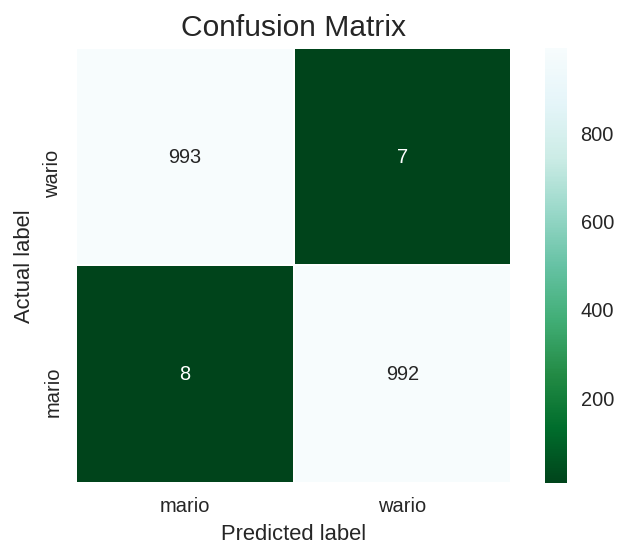

In [59]:
pretty_cm(y_pred, y_true, classes)

Accuracy of 99%, sweet! Let's see some more detailed statistics: 
*  99.2% Recall - This means that from all wario screenshots in the dataset the model correctly predicts 99.2% of them.
*  99.3% Precision - This means that from all the wario predictions 99.3% of them were actually wario.
*  99.25% F1 Score - There is no clear interpretation for this one as F1 Score is the weighted average of Precision and Recall. F1 is more useful than accuracy in case of uneven class distribution. As in this case there is an equal number of mario/wario classes in the test set, accuracy = F1 Score.

The network in general does an amazing job in classifying the images. Only 15 incorrectly classified images out of 2000. To get more insight, we will inspect some of them below.

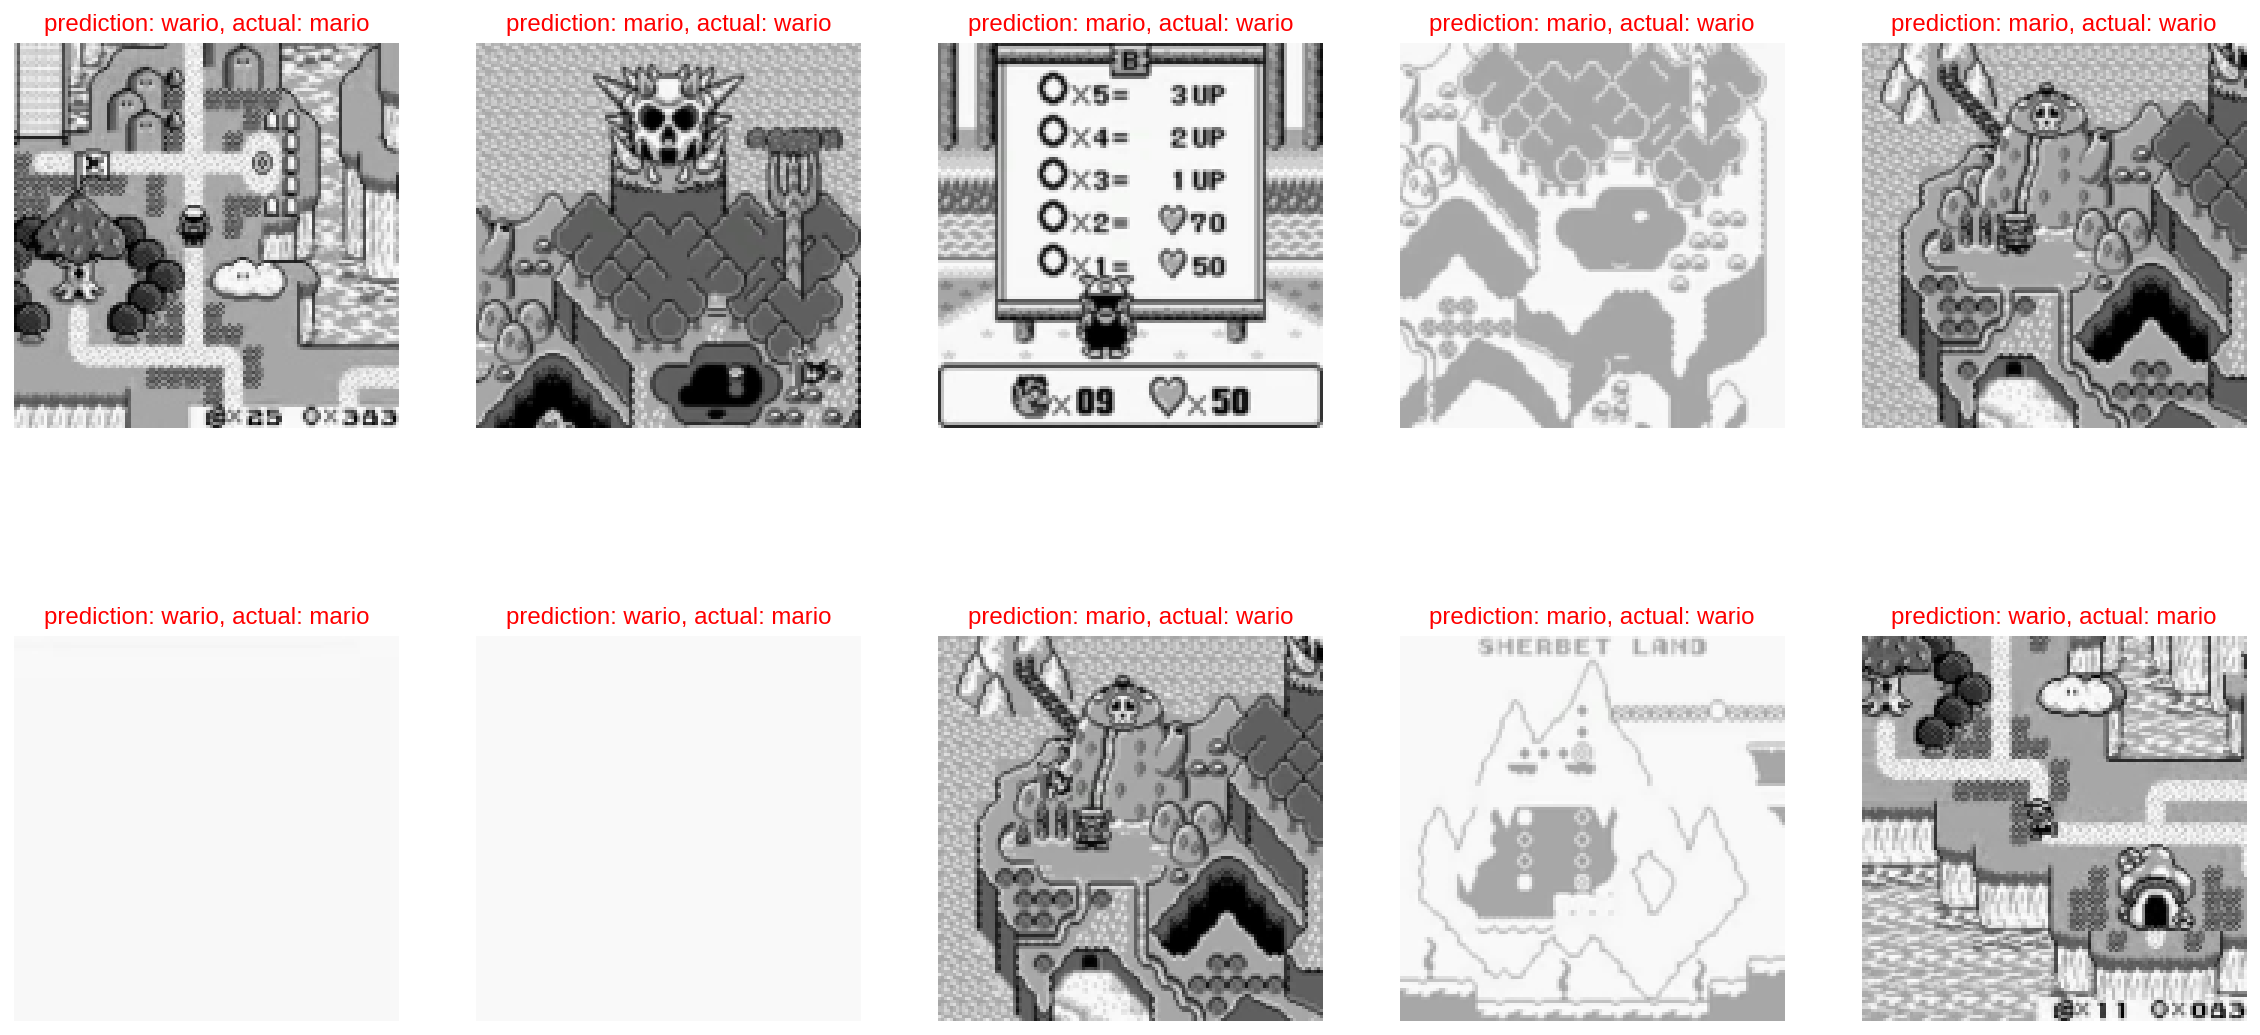

In [64]:
# inspect the incorrectly classified images
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(incorrect_images[idx])
    ax.set_title("prediction: {}, actual: {}".format(classes[incorrect_label[idx]], classes[true_label[idx]]),
                 color=("green" if incorrect_label[idx]==true_label[idx] else "red"))

I have to say that it is not that weird that the network had troubles with these images. Some of them are obviously transition frames from the game. There was no way to infer the correct game from those. The rest of them are maps or a specific screen from Wario (first image). The maps from these games were pretty similar, just as the characters seen from the isometric view. 

I have to say that I am very satisfied with this network's performance and with PyTorch in general. It offers a lot of possibilities and is quite pythonic. For more information about basics of PyTorch I would refer you to Udacity's free `Intro to Deep Learning with PyTorch` MOOC, which you can find [here](https://www.udacity.com/course/deep-learning-pytorch--ud188). 